In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, BasicAer, Aer, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram, array_to_latex


# IICQ Project

The goal of this project is to show how to build quantum circuits using qiskit.

The first step is let people what Qiskit is and how to actually acess it (this is a python library yada yada yada) - Only done in ppt

The second step is to actually show how you can manipulate the basic properties of the circuit:

- How to initialize the register (all in littleEndian but clarify it can be changed)
- How to initialize the state
- How to acess the state vector  
- How to make controlled gates (littleEndian)
- How to measure
- How to simulate the circuit 
- How to draw

The third step is to show some known algorithms in Qiskit

- Grover's or Deutsche-Jostza or both (this is good practice for the test)
- Maybe even some cryptographic protocol! (No theory, just for show remember this is 15 mins)

## Initialization

- Use QuantumRegister(n) and ClassicalRegister(k), this way you can actually acess the qubits and bits. Then use QuantumCircuit(n, k)
- By default each qubit is set to the set $\ket{0}$.
- You can initialize the qubits by labelling with a string (e.g '001') or by using a list separated by commas. This values in this list are the scalars for the basis vectors. Be mindful of littleEndian!

We give some ordering examples:

- For a two-qubit system: $\ket{00} \ket{01} \ket{10} \ket{11}$

- For a three-qubit system : $\ket{000} \ket{001} \ket{010} \ket{011} \ket{100} \ket{101} \ket{110} \ket{111}$

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [3]:
# Helps with initialization. Default 0 since we might not need a classical register.
def quantum_initialization(n, k = 0):
    q = QuantumRegister(n)
    c = ClassicalRegister(k)

    qc = QuantumCircuit(n, k)

    return q, c, qc

In [4]:
# Initialization
q, c, qc = quantum_initialization(3)

qc.initialize([1, 0, 0, 0, 0, 0, 0, 0], qc.qubits)

st0 = Statevector(qc)
st0.draw(output='latex')

<IPython.core.display.Latex object>

In [5]:
qc.initialize('000', qc.qubits)

st0 = Statevector(qc)
st0.draw(output='latex')

<IPython.core.display.Latex object>

## Making Gates

Now that we know how to initialize our state lets try to make a very simple gate. For example, let's look at the Flip Operator (from PSET9)

The circuit is composed of three qubits and five gates: 4 X gates and 1 CCZ gate

To make the gates we just need to type qc."gate"("index of qubit"). If this gate is controlled we first arguments are the control qubits and the last is the target qubit.

The X gates are acting on the second and third qubit.

The CCZ gate acts on the first qubit.

We write the circuit from left to right

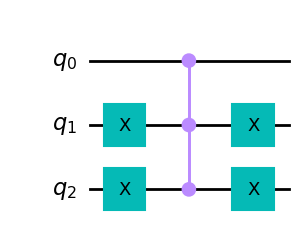

In [6]:

q, c, qc = quantum_initialization(3)

qc.x(1) 

qc.x(2)

qc.ccz(1, 2, 0)

qc.x(1)

qc.x(2)

qc.draw('mpl')

Now that our circuit is made let us apply it to our basis states

In [7]:
basis = ["000", "001", "010", "011", "100", "101", "110", "111"]

for index in basis:

    state = Statevector.from_label(index)

    state.evolve(qc).draw(output='latex')

We can also see it in matrix form using a simulation

The way you perform simulations is by calling a backend and then transpiling the circuit

In [8]:
backend = Aer.get_backend('unitary_simulator')
job = backend.run(transpile(qc, backend))
result = job.result().get_unitary(qc, decimals=3)

array_to_latex(result, prefix="\\text{U = }")

<IPython.core.display.Latex object>

# Measuring

We move on to a more complex task. In PSET8 there is a gate that allows us to measure the overlap between a state a and a state b. Let us actually calculate it.

To actually do this we generate random states for the second and third qubits.

Then we pass those qubits through the circuit and measure

Then we analyze the histogram

Then we are able to actually compute the overlap!

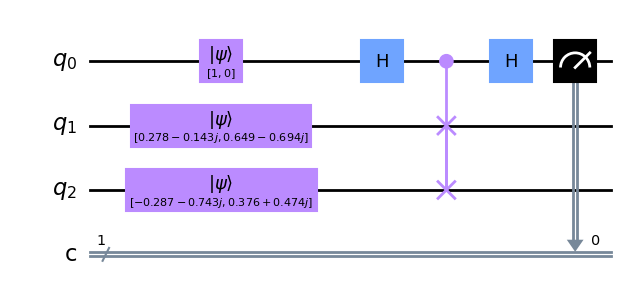

In [9]:
from qiskit.quantum_info import random_statevector
q, c, qc = quantum_initialization(3, 1)

state_a = random_statevector(2)

state_b = random_statevector(2)

qc.initialize([1, 0], 0)
qc.initialize(state_a, 1)
qc.initialize(state_b, 2)

qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

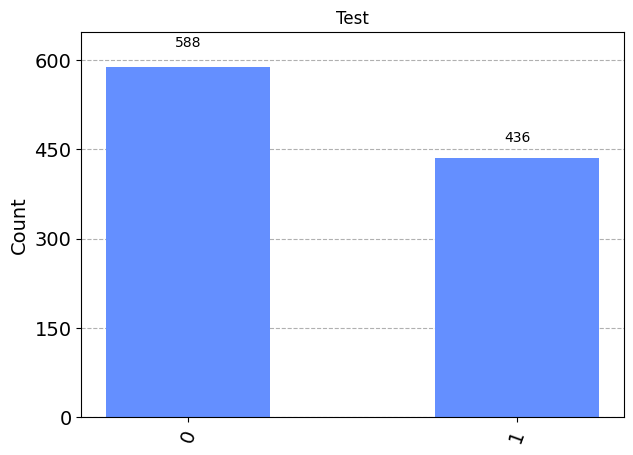

In [10]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

result = simulator.run(qc).result()
counts = result.get_counts(qc)

plot_histogram(counts, title='Test')

In [11]:
def overlap(runs):
    i = 0
    while i < runs:
        q, c, qc = quantum_initialization(3, 1)

        state_a = random_statevector(2)

        state_b = random_statevector(2)

        actual_prob = 0.5 * ( 1 + np.abs((state_a.inner(state_b))) ** 2)

        qc.initialize([1, 0], 0)
        qc.initialize(state_a, 1)
        qc.initialize(state_b, 2)

        qc.h(0)
        qc.cswap(0, 1, 2)
        qc.h(0)
        qc.measure(0, 0)

        circ = transpile(qc, simulator)

        result = simulator.run(qc).result()
        counts = result.get_counts(qc)

        measured_prob =  counts.get('0') / (counts.get('0') + counts.get('1'))

        print("Actual prob: " + str(actual_prob) + ", Measured prob: " + str(measured_prob) + ", Difference: " + str(np.abs(actual_prob-measured_prob)))

        i = i + 1

In [12]:
overlap(10)

Actual prob: 0.9343404104847033, Measured prob: 0.9462890625, Difference: 0.011948652015296712
Actual prob: 0.5434341249078537, Measured prob: 0.52734375, Difference: 0.0160903749078537
Actual prob: 0.799178189609488, Measured prob: 0.8046875, Difference: 0.005509310390511946
Actual prob: 0.607544899792418, Measured prob: 0.6259765625, Difference: 0.01843166270758201
Actual prob: 0.7292646601006298, Measured prob: 0.7470703125, Difference: 0.017805652399370153
Actual prob: 0.5983315060004997, Measured prob: 0.578125, Difference: 0.02020650600049967
Actual prob: 0.8672084590338109, Measured prob: 0.8583984375, Difference: 0.008810021533810941
Actual prob: 0.7979685596757924, Measured prob: 0.7900390625, Difference: 0.007929497175792388
Actual prob: 0.8871400621974532, Measured prob: 0.904296875, Difference: 0.017156812802546773
Actual prob: 0.5689856256520507, Measured prob: 0.57421875, Difference: 0.005233124347949314


## Advanced Algorithms

Let's try and make the Deutsch algorithm given in class.

We want to know if given $f: {0,1} \to {0,1}$ we can determine if it is constant by just calling it once.

We begin with the qubit $\ket{0}\ket{1}$

We start by making the constant oracle

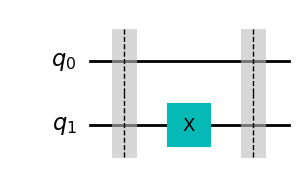

In [13]:
n = 1

const_orac = QuantumCircuit(n + 1)

const_orac.barrier()
output = np.random.randint(2)
if output == 1:
    const_orac.x(n)
const_orac.barrier()


const_orac.draw('mpl')

To make a balanced oracle we have to decide which inputs give 0 and which inputs give 1 with the guarantee that it is balanced. 

We could just make A balanced oracle representing A function f. But there are many balanced functions so it makes sense to have many oracles (generalization)

For n = 1 we only have two options, either $f(0) = 0$ and $f(1) = 1$ or $f(0) = 1$ and $f(1) = 0$

We can use X gates together with CNOT for every control qubit on the register make such functions

Let's make both



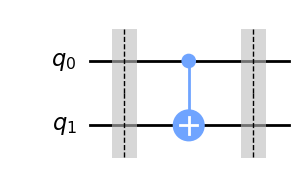

In [14]:
balanced_orac1 = QuantumCircuit(n + 1)
balanced_orac1.barrier()
balanced_orac1.cnot(0, 1)
balanced_orac1.barrier()
balanced_orac1.draw('mpl')

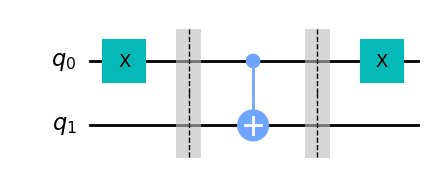

In [15]:
balanced_orac2 = QuantumCircuit(n + 1)
balanced_orac2.x(0)
balanced_orac2.barrier()
balanced_orac2.cnot(0, 1)
balanced_orac2.barrier()
balanced_orac2.x(0)
balanced_orac2.draw('mpl')

Now that we have our three oracles let's put the algorithm together.

The first step is to initialize the first qubit to the $\ket{+}$ state and the second qubit to the $\ket{-}$ state. Then we apply our oracle

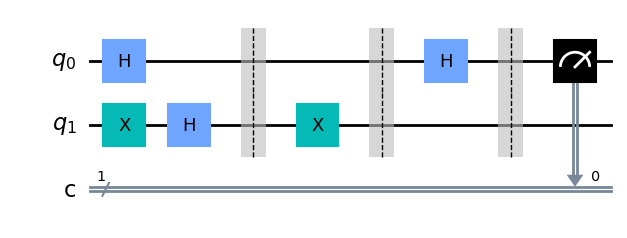

In [16]:
dj_qc = QuantumCircuit(n + 1, n)

dj_qc.h(0)

dj_qc.x(1)
dj_qc.h(1)

dj_qc = dj_qc.compose(const_orac)

dj_qc.h(0)
dj_qc.barrier()

dj_qc.measure(0, 0)
dj_qc.draw('mpl')



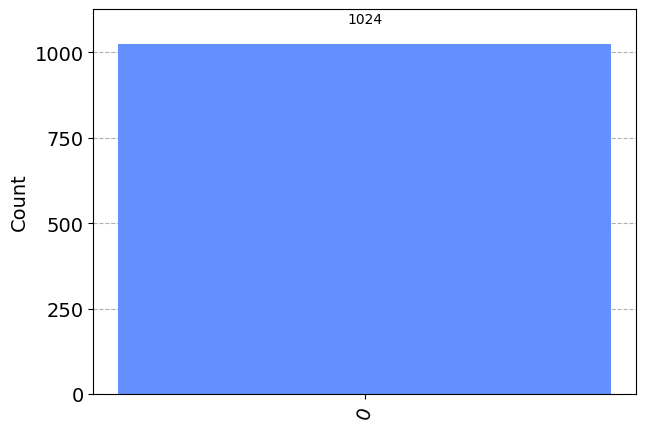

In [17]:
circ = transpile(dj_qc, simulator)

result = simulator.run(dj_qc).result()
counts = result.get_counts(dj_qc)

plot_histogram(counts)

Let's do the same for our balanced oracles

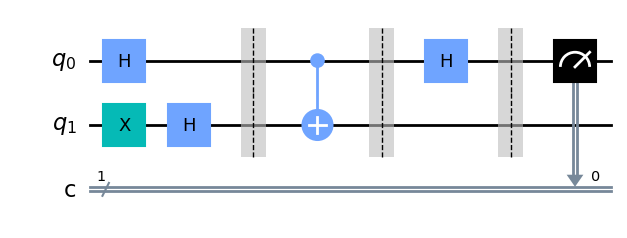

In [18]:
dj_qc = QuantumCircuit(n + 1, n)

dj_qc.h(0)

dj_qc.x(1)
dj_qc.h(1)

dj_qc = dj_qc.compose(balanced_orac1)

dj_qc.h(0)
dj_qc.barrier()

dj_qc.measure(0, 0)
dj_qc.draw('mpl')

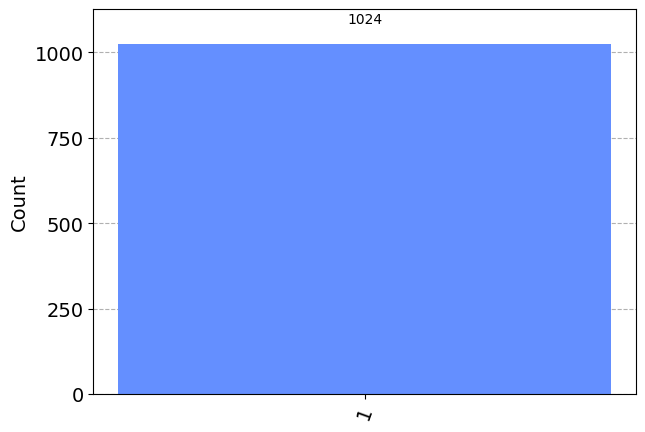

In [19]:
circ = transpile(dj_qc, simulator)

result = simulator.run(dj_qc).result()
counts = result.get_counts(dj_qc)

plot_histogram(counts)

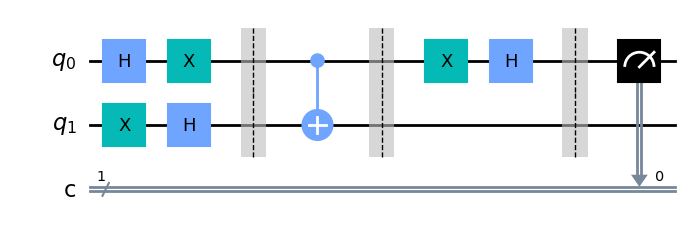

In [20]:
dj_qc = QuantumCircuit(n + 1, n)

dj_qc.h(0)

dj_qc.x(1)
dj_qc.h(1)

dj_qc = dj_qc.compose(balanced_orac2)

dj_qc.h(0)
dj_qc.barrier()

dj_qc.measure(0, 0)
dj_qc.draw('mpl')

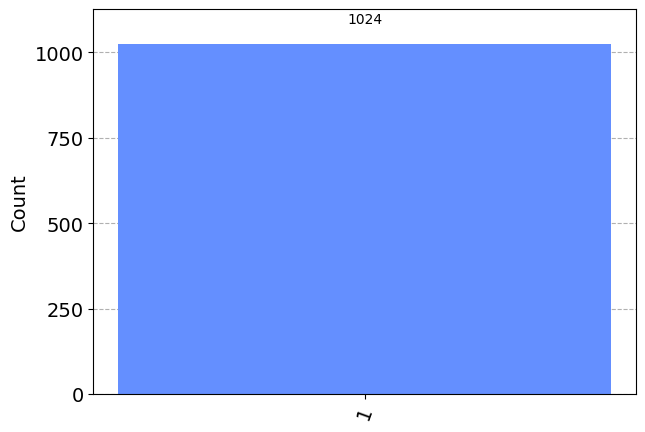

In [21]:
circ = transpile(dj_qc, simulator)

result = simulator.run(dj_qc).result()
counts = result.get_counts(dj_qc)

plot_histogram(counts)

Now let's generalize this algorithm

In [22]:
import random as rand

def my_oracle(type, n):

    oracle = QuantumCircuit(n + 1)

    if type == "c":
        output = np.random.randint(2)
        if output == 1:
            oracle.x(n)
    
    if type == "b":
        b_list = []
        for i in range(n):
            b_list.append(rand.randint(0,1))
            if b_list[i] == 1:
                oracle.x(i)

        oracle.barrier()
        
        for i in range(n):
            oracle.cx(i, n)

        oracle.barrier()

        for i in range(n):
            if b_list[i] == 1:
                oracle.x(i)

    return oracle

    

def my_dj(oracle, n):
    dj = QuantumCircuit(n + 1, n)

    dj.x(n)
    dj.h(n)

    for i in range(n):
        dj.h(i)
    
    dj = dj.compose(oracle, range(n + 1))

    for i in range(n):
        dj.h(i)
    
    dj.barrier()
    
    for i in range(n):
        dj.measure(i,i)
    
    return dj

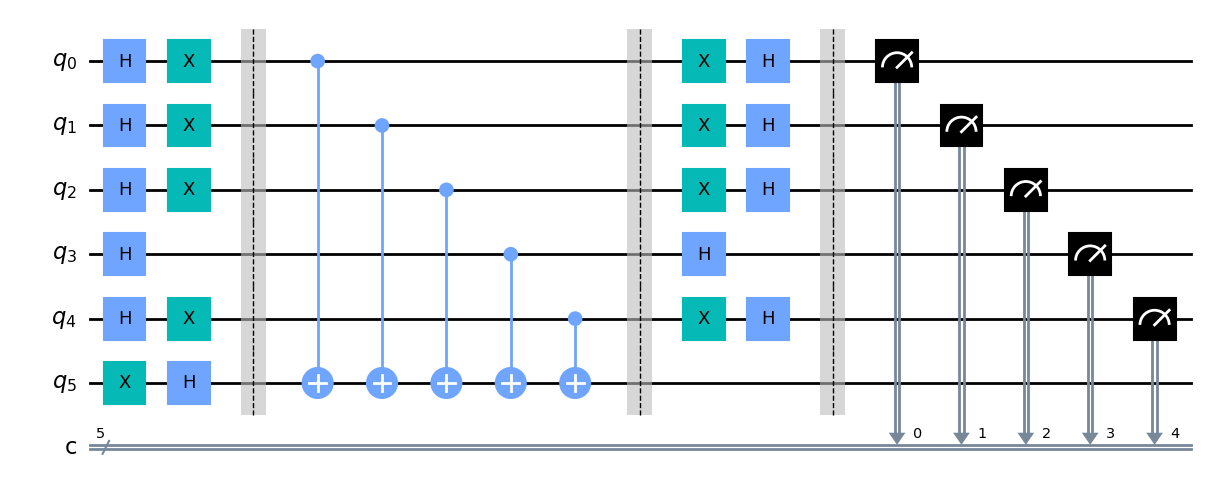

In [167]:
n = 5

oracle = my_oracle("b", n)
dj = my_dj(oracle, n)

dj.draw("mpl")

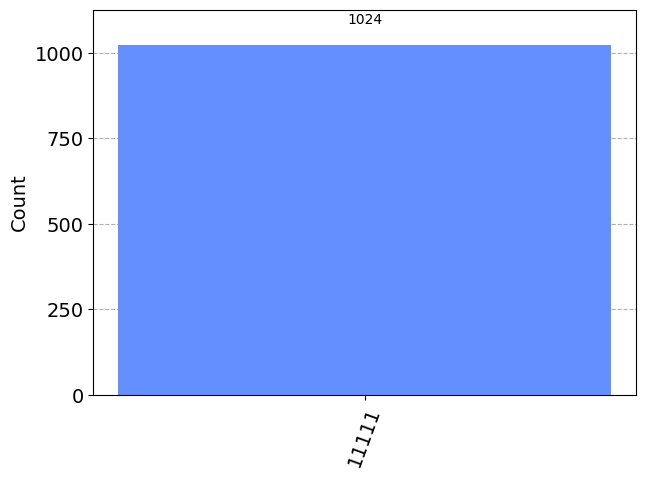

In [168]:
circ = transpile(dj, simulator)

result = simulator.run(dj).result()
counts = result.get_counts(dj)

plot_histogram(counts)

# Grover's Algorithm

Let's try to make Grover's Algorithm

The first step is to actually make the Oracle

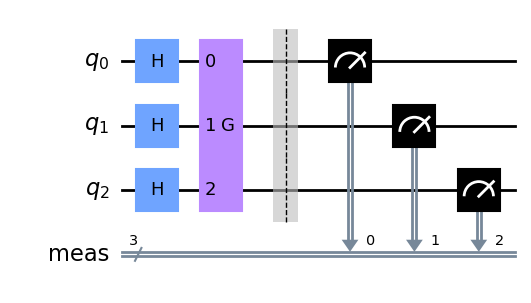

In [230]:
# Define global list size
N = 5

# We work with normal indexes. It's easier this way (0 ... N-1)
solutions = [0, 4]

def grover_G(N, solutions):

    n = int(np.ceil(np.log2(N)))

    qc = QuantumCircuit(n)

    # Oracle
    U = np.identity(2 ** n)
    for ind in solutions:
            U[ind][ind] = U[ind][ind] * -1

    qc.unitary(U, range(n))

    # Amplifier
    for qubit in range(n):
        qc.h(qubit)
        qc.x(qubit)
    
    # Controlled Z can be decomposed into hadamard and toffoli
    qc.h(n - 1)
    qc.mct(list(range(n-1)), n - 1)
    qc.h(n - 1)

    for qubit in range(n):
        qc.x(qubit)
        qc.h(qubit)
    
    # Gate Creation
    G_gate = qc.to_gate()
    G_gate.name = "G"

    return G_gate


def grover(N, solutions, iter):

    n = int(np.ceil(np.log2(N)))

    qc = QuantumCircuit(n)

    for qubit in range(n):
        qc.h(qubit)
    for i in range(iter):
        qc.append(grover_G(N, solutions), range(n))
    qc.measure_all()
    return qc

qc = grover(N, solutions, 1)
qc.draw('mpl')

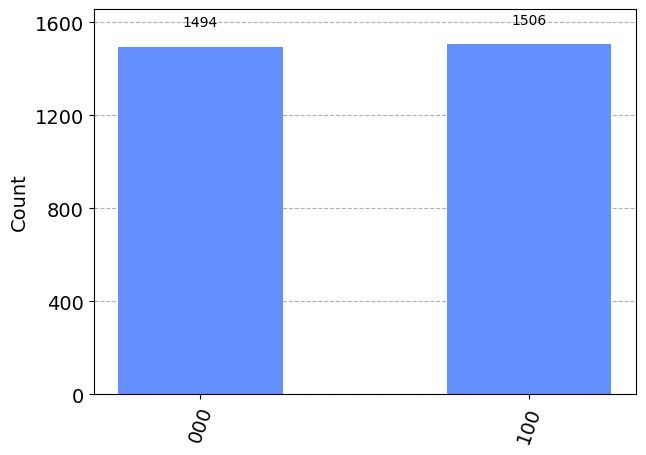

In [231]:
transpiled_grover_circuit = transpile(qc, simulator)
qobj = assemble(transpiled_grover_circuit)
results = simulator.run(qobj, shots = 3000).result()
counts = results.get_counts()
plot_histogram(counts)

1


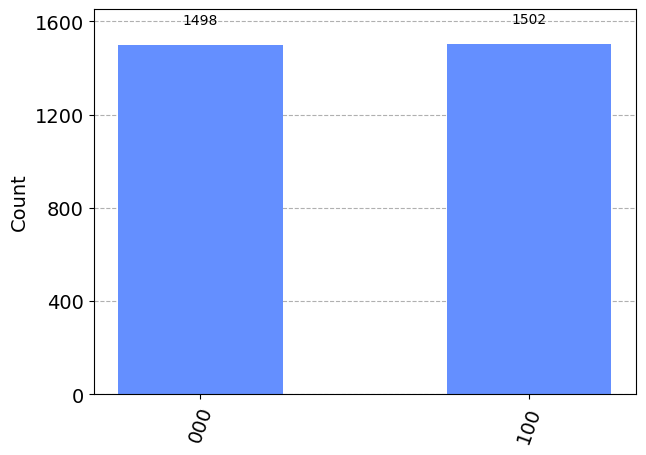

In [232]:
import matplotlib.pyplot as plt

def best_grover_n(N, solutions, shots = 3000):

    M = len(solutions)

    if M >= N / 2:
        N = 2 * N

    iter = int(np.floor((np.pi / 4) * np.sqrt(N/M)) )

    print(iter)

    qc = grover(N, solutions, iter)
    transpiled_grover_circuit = transpile(qc, simulator)
    qobj = assemble(transpiled_grover_circuit)
    results = simulator.run(qobj, shots = shots).result()
    counts = results.get_counts()

    return plot_histogram(counts)

best_grover_n(N, solutions)


1


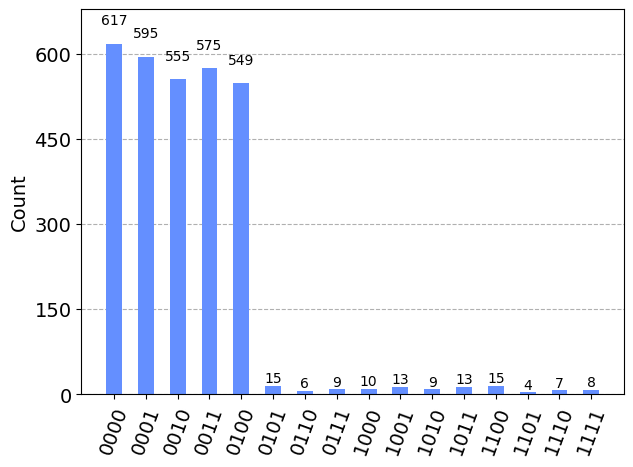

In [243]:
def make_solutions(N, M = 'r'):

    solutions = []

    indexes = list(range(N))

    if M == 'r':
        # Gives number of solutions
        M = rand.randint(1, N)
    
    # Making M random solutions
    for i in range(M):
        rand_ind = rand.choice(indexes)
        solutions.append(rand_ind)
        indexes.remove(rand_ind)
    
    return solutions

solutions = make_solutions(N)

best_grover_n(N, solutions)